In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
# Install required libraries
!pip install rasterio geopandas tensorflow scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 71.1 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import rasterio
from rasterio.plot import show
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap

(2217, 2925, 19)


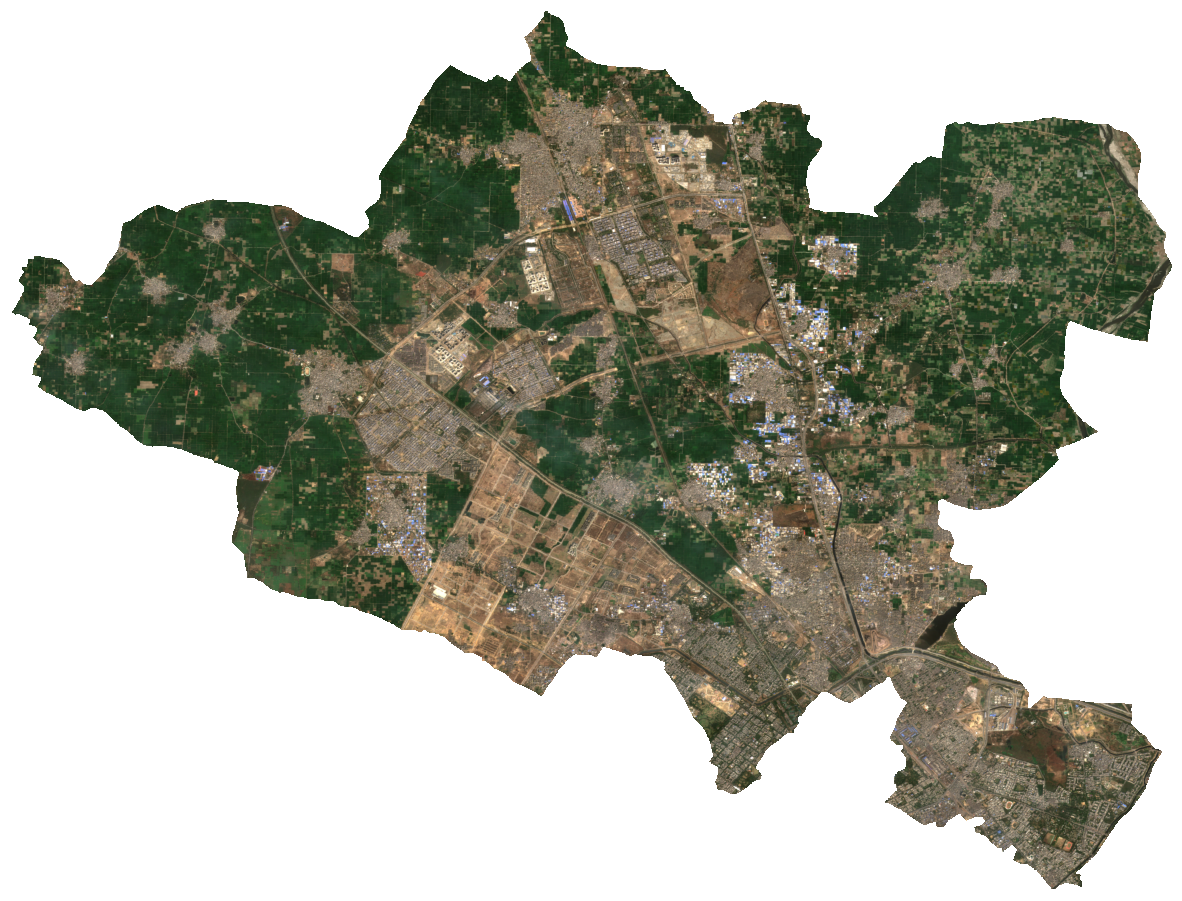

In [ ]:

# Load Sentinel-2 image (GeoTIFF)
path_img = '/content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI_2019_composite.tif'
src = rasterio.open(path_img)

# Read image data (19 bands)
img = src.read()

img = img.transpose([1, 2, 0])  # Reshape to (height, width, bands)
print(img.shape)
# Select RGB bands for visualization
red = img[:, :, 3]
green = img[:, :, 2]
blue = img[:, :, 1]
rgb = np.dstack((red, green, blue))

# Plot RGB image
plt.figure(figsize=[15, 15])
plt.imshow(rgb * 4)  # Adjust contrast
plt.axis('off')
plt.show()

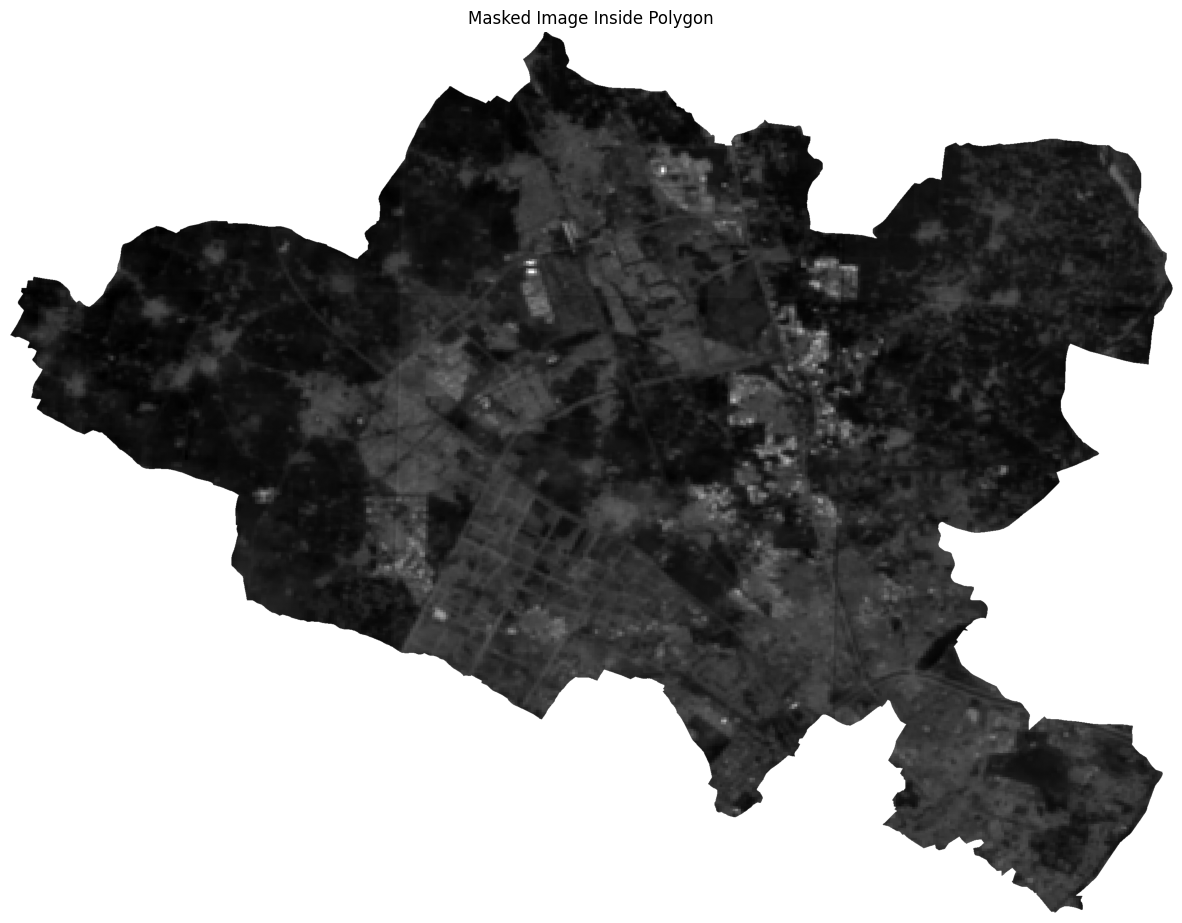

In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
import matplotlib.pyplot as plt

# Load Sentinel-2 image (GeoTIFF)
path_img = '/content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI_2019_composite.tif'
src = rasterio.open(path_img)

# Read the polygon shapefile that defines the region of interest (ROI)
path_shapefile = '/content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI.shp'  # Replace with your actual path
roi_polygon = gpd.read_file(path_shapefile)

# Ensure the shapefile and image are in the same CRS (coordinate reference system)
roi_polygon = roi_polygon.to_crs(src.crs)

# Mask the image with the polygon shapefile (ROI)
# This returns the data within the polygon, and the affine transform
out_image, out_transform = mask(src, roi_polygon.geometry, crop=True)

# Mask the image (sets outside pixels to NaN)
out_image = np.ma.masked_equal(out_image, 0)  # Assuming 0 is the value for 'no data'

# Visualize the masked image (only the region inside the polygon)
plt.figure(figsize=(15, 15))
plt.imshow(out_image[0], cmap='gray')  # Assuming you want to display the first band
plt.title("Masked Image Inside Polygon")
plt.axis('off')
plt.show()


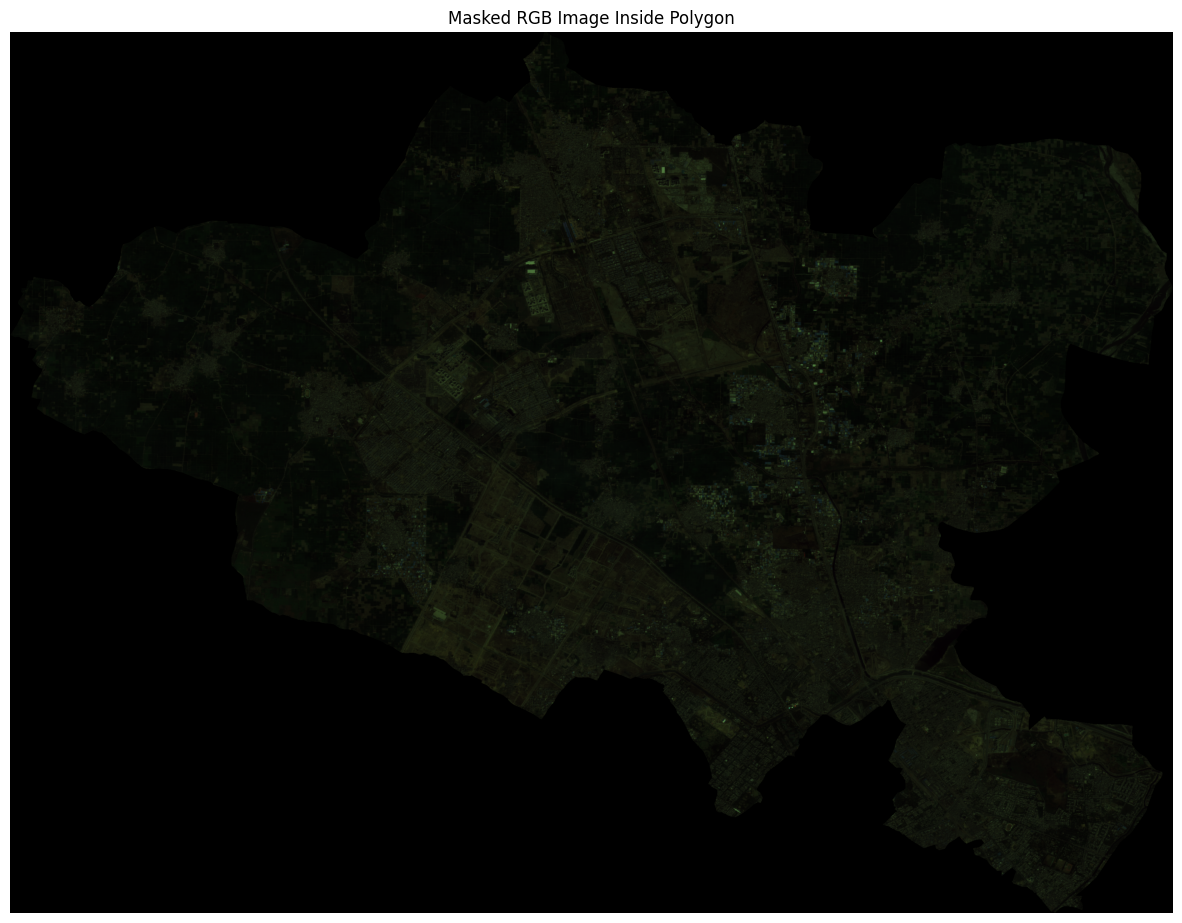

In [ ]:
import rasterio
import geopandas as gpd
import numpy as np
from rasterio.mask import mask
import matplotlib.pyplot as plt

# Load Sentinel-2 image (GeoTIFF)
path_img = '/content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI_2019_composite.tif'
src = rasterio.open(path_img)

# Read the polygon shapefile that defines the region of interest (ROI)
path_shapefile = '/content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI.shp'  # Replace with your actual path
roi_polygon = gpd.read_file(path_shapefile)

# Ensure the shapefile and image are in the same CRS (coordinate reference system)
roi_polygon = roi_polygon.to_crs(src.crs)

# Mask the image with the polygon shapefile (ROI)
out_image, out_transform = mask(src, roi_polygon.geometry, crop=True)

# Mask the image (sets outside pixels to NaN)
out_image = np.ma.masked_equal(out_image, 0)  # Assuming 0 is the value for 'no data'

# Extract the RGB bands (Assuming bands 4, 3, 2 correspond to RGB)
# Sentinel-2: Band 4 = Red, Band 3 = Green, Band 2 = Blue
red = out_image[3]  # Band 4 (Red)
green = out_image[2]  # Band 3 (Green)
blue = out_image[1]  # Band 2 (Blue)

# Perform contrast stretching (scaling to the range [0, 1] or [0, 255])
def contrast_stretching(band):
    band_min = np.min(band)
    band_max = np.max(band)
    band_stretched = (band - band_min) / (band_max - band_min)  # Normalize to [0, 1]
    return band_stretched

# Apply contrast stretching to each RGB band
red_stretched = contrast_stretching(red)
green_stretched = contrast_stretching(green)
blue_stretched = contrast_stretching(blue)

# Stack the RGB bands to create the RGB image
rgb = np.stack((red_stretched, green_stretched, blue_stretched), axis=-1)

# Display the RGB image
plt.figure(figsize=(15, 15))
plt.imshow(rgb)  # Now using the stretched values
plt.title("Masked RGB Image Inside Polygon")
plt.axis('off')  # Hide axes for better visualization
plt.show()


In [ ]:
samples = gpd.read_file('/content/drive/MyDrive/NORTH_DELHI_19IN_2019/new_point_NORTH_DELHI_2019.shp')
samples2 = samples.to_crs('EPSG:4326')

<Axes: >

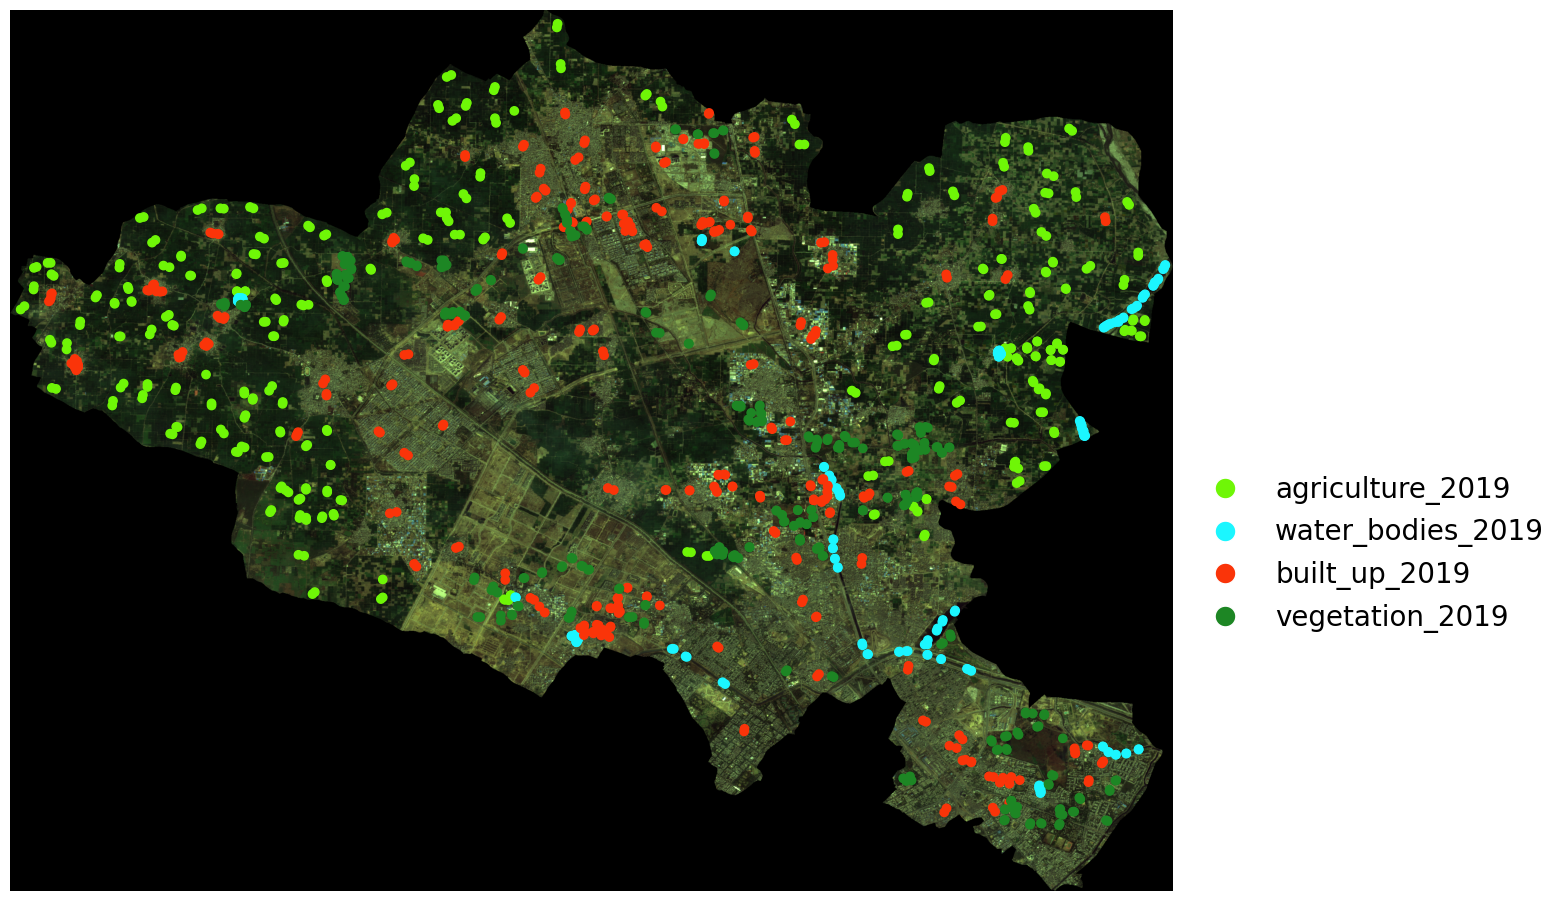

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D  # For creating colored circles in legend

# Define the color map
cmap = ListedColormap(['#6ff607', '#1bf6ff' , '#fa3409', '#1d8624'])

# Define the class-to-number mapping
class_to_index = {
    'agriculture_2019': 0,
    'water_bodies_2019': 1,
    'built_up_2019': 2,
    'vegetation_2019': 3
}

# Recode the 'sam_classN' column to numeric indices
samples2['sam_classN_num'] = samples2['sam_classN'].map(class_to_index)

# Plotting
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the classified data, using the numeric values for coloring
samples2.plot(column='sam_classN_num', categorical=True, cmap=cmap, legend=False, ax=ax)

# Manually create the legend with class names
legend_labels = ['agriculture_2019', 'water_bodies_2019', 'built_up_2019', 'vegetation_2019']
legend_colors = ['#6ff607', '#1bf6ff' , '#fa3409', '#1d8624']

# Create legend handles as colored circles (Line2D with marker='o')
legend_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=15, label=label)
                  for label, color in zip(legend_labels, legend_colors)]

# Add the legend to the plot
ax.legend(handles=legend_handles, bbox_to_anchor=(1, 0.5), loc='upper left', fontsize=20, frameon=False)

# Hide axes for better visualization
ax.axis('off')

# Assuming 'rgb' is your RGB image (e.g., from Sentinel-2), and 'src' is the source metadata (transform)
#show(rgb.transpose([2, 0, 1]) * 4, transform=src.transform, ax=ax)

#show(rgb.transpose([2, 0, 1]) * 4, transform=raster_objects['B1'].transform, ax=ax)
show(rgb.transpose([2, 0, 1]) * 4, transform=src.transform, ax=ax)


In [ ]:
samples2['geometry']

0       POINT (77.18577 28.82726)
1       POINT (77.18594 28.82722)
2       POINT (77.18161 28.82508)
3       POINT (77.18178 28.82489)
4       POINT (77.19744 28.82662)
                  ...            
1263    POINT (77.08644 28.75759)
1264    POINT (77.09237 28.75699)
1265    POINT (77.09262 28.75704)
1266    POINT (77.09119 28.75776)
1267    POINT (77.09091 28.75789)
Name: geometry, Length: 1268, dtype: geometry

In [ ]:
array_samples = []
for point in samples2['geometry']:
  x = point.xy[0][0]
  y = point.xy[1][0]
  row, col = src.index(x, y)
  band_value = []
  for i in range(src.count):
    band_value.append(src.read(i+1)[row, col])
  array_samples.append(band_value)



In [ ]:
X = np.array(array_samples)
X.shape

(1268, 19)

In [ ]:
# Reshape the input data to fit CNN format: (samples, features, 1)
X_reshaped = X.reshape(X.shape[0], X.shape[1], 1)  # Shape: (n_samples, n_features, 1)

# Check the reshaped data shape
print(X_reshaped.shape)  # Should output (samples, bands, 1)


(1268, 19, 1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
samples2['sam_classN']

0       agriculture_2019
1       agriculture_2019
2       agriculture_2019
3       agriculture_2019
4       agriculture_2019
              ...       
1263     vegetation_2019
1264     vegetation_2019
1265     vegetation_2019
1266     vegetation_2019
1267     vegetation_2019
Name: sam_classN, Length: 1268, dtype: object

In [ ]:
Y = samples2['sam_classN'].values

In [ ]:
import numpy as np

# Define the mapping
class_mapping = {'agriculture_2019': 0, 'water_bodies_2019': 1,  'built_up_2019': 2,  'vegetation_2019': 3}

# Map the classes to integers
Y_encoded = np.array([class_mapping[label] for label in Y])
#print(Y_encoded)

In [ ]:
Y_onehot = tf.keras.utils.to_categorical(Y_encoded)  # Convert to one-hot encoding

# Check the shape of the one-hot encoded labels
print(Y_onehot.shape)  # Should output (samples, num_classes)

(1268, 4)


In [ ]:
X= X_reshaped
Y = Y_onehot

In [ ]:
from sklearn.model_selection import train_test_split

# Step 1: Split the data into training and temporary sets (for validation + testing)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)

# Step 2: Split the temporary data into validation and testing sets
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=2/3, random_state=42)

# Check the shapes of the datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("Y_train shape:", Y_train.shape)
print("Y_val shape:", Y_val.shape)
print("Y_test shape:", Y_test.shape)


X_train shape: (887, 19, 1)
X_val shape: (127, 19, 1)
X_test shape: (254, 19, 1)
Y_train shape: (887, 4)
Y_val shape: (127, 4)
Y_test shape: (254, 4)


# Inspecting class imbalances

The distribution of your samples across the different sets (total, training, validation, and testing)

In [ ]:
import numpy as np
from collections import Counter

# Assuming Y is your labels, which is a one-hot encoded array, and you split the data as before:

# Convert one-hot encoded labels back to class indices for easy counting
y_train_classes = np.argmax(Y_train, axis=1)
y_val_classes = np.argmax(Y_val, axis=1)
y_test_classes = np.argmax(Y_test, axis=1)
y_total_classes = np.argmax(Y, axis=1)  # Total labels (before splitting)

# Count the number of samples for each class in total, training, validation, and testing sets
total_class_counts = Counter(y_total_classes)
train_class_counts = Counter(y_train_classes)
val_class_counts = Counter(y_val_classes)
test_class_counts = Counter(y_test_classes)

# Assuming you have a mapping similar to your 'class_mapping'
# that maps class indices to class names:
class_labels = ['agriculture_2024', 'water_bodies_2024', 'built_up_2024', 'vegetation_2024']

# Display the class distribution
print("Class distribution in the total dataset:")
for class_index, count in total_class_counts.items():
    print(f"Class {class_labels[class_index]}: {count} samples")

print("\nClass distribution in the training set:")
for class_index, count in train_class_counts.items():
    print(f"Class {class_labels[class_index]}: {count} samples")

print("\nClass distribution in the validation set:")
for class_index, count in val_class_counts.items():
    print(f"Class {class_labels[class_index]}: {count} samples")

print("\nClass distribution in the testing set:")
for class_index, count in test_class_counts.items():
    print(f"Class {class_labels[class_index]}: {count} samples")

# Check for class imbalance by looking at the distributions
# You can compare the distribution across all datasets to see if any class is underrepresented in the training set.

Class distribution in the total dataset:
Class agriculture_2024: 356 samples
Class water_bodies_2024: 202 samples
Class built_up_2024: 340 samples
Class vegetation_2024: 370 samples

Class distribution in the training set:
Class vegetation_2024: 256 samples
Class built_up_2024: 247 samples
Class agriculture_2024: 244 samples
Class water_bodies_2024: 140 samples

Class distribution in the validation set:
Class agriculture_2024: 36 samples
Class built_up_2024: 35 samples
Class water_bodies_2024: 21 samples
Class vegetation_2024: 35 samples

Class distribution in the testing set:
Class built_up_2024: 58 samples
Class vegetation_2024: 79 samples
Class water_bodies_2024: 41 samples
Class agriculture_2024: 76 samples


Visually inspect potential class imbalances

<Figure size 800x600 with 0 Axes>

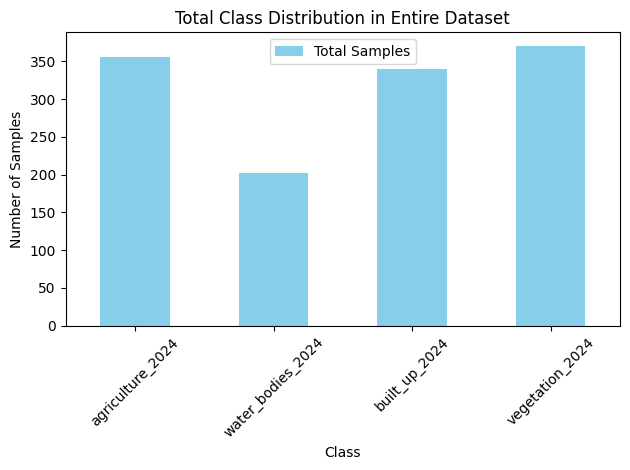

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Count the occurrences of each class in the entire dataset
total_class_counts = pd.Series(Y.argmax(axis=1)).value_counts().sort_index()

# Create a DataFrame to hold the counts for easier plotting
total_class_counts_df = pd.DataFrame({
    'Total Samples': total_class_counts
}).fillna(0)  # Handle any missing class labels

# Set class labels as the index
total_class_counts_df.index = class_labels

# Plotting
plt.figure(figsize=(8, 6))
total_class_counts_df.plot(kind='bar', color='skyblue')
plt.title('Total Class Distribution in Entire Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()


Visually inspect training, validation, testing

<Figure size 1200x600 with 0 Axes>

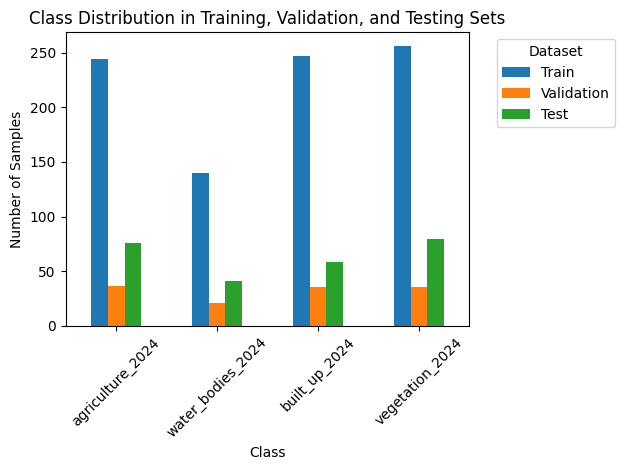

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming you have the class distributions in the form of lists or arrays
# Example: counts for training, validation, and testing sets

# Class labels for your dataset
class_labels = ['agriculture_2024', 'water_bodies_2024', 'built_up_2024', 'vegetation_2024']

# Count the occurrences of each class in the training, validation, and testing sets
train_class_counts = pd.Series(Y_train.argmax(axis=1)).value_counts().sort_index()
val_class_counts = pd.Series(Y_val.argmax(axis=1)).value_counts().sort_index()
test_class_counts = pd.Series(Y_test.argmax(axis=1)).value_counts().sort_index()

# Create a DataFrame to hold the counts for easier plotting
df_counts = pd.DataFrame({
    'Train': train_class_counts,
    'Validation': val_class_counts,
    'Test': test_class_counts
}).fillna(0)  # Handle any missing class labels in the sets

# Set class labels as the index
df_counts.index = class_labels

# Plotting
plt.figure(figsize=(12, 6))
df_counts.plot(kind='bar', stacked=False)
plt.title('Class Distribution in Training, Validation, and Testing Sets')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.legend(title='Dataset', labels=['Train', 'Validation', 'Test'], bbox_to_anchor=(1.05, 1), loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


# Defining model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', padding='same', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(2))

model.add(Conv1D(128, 3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(Y_onehot.shape[1], activation='softmax'))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 19, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 9, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 9, 128)         │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,140 (356.02 KB)

 Trainable params: 91,140 (356.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Print the model compilation details
print("Model Compilation Status: ")
print(f"Optimizer: {model.optimizer.get_config()}")
print(f"Loss function: {model.loss}")
print(f"Metrics: {model.metrics_names}")


Model Compilation Status: 
Optimizer: {'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Loss function: categorical_crossentropy
Metrics: ['loss', 'compile_metrics']


Model Training

In [ ]:
# Train the model
history = model.fit(X_train, Y_train, epochs=200, batch_size=32, validation_data=(X_val, Y_val))

Epoch 1/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3197 - loss: 1.3282 - val_accuracy: 0.8976 - val_loss: 1.0783
Epoch 2/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8406 - loss: 0.9347 - val_accuracy: 0.9370 - val_loss: 0.4899
Epoch 3/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9010 - loss: 0.5030 - val_accuracy: 0.9291 - val_loss: 0.2954
Epoch 4/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9057 - loss: 0.4004 - val_accuracy: 0.9291 - val_loss: 0.2454
Epoch 5/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9029 - loss: 0.3269 - val_accuracy: 0.9449 - val_loss: 0.2131
Epoch 6/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9222 - loss: 0.2961 - val_accuracy: 0.9449 - val_loss: 0.2157
Epoch 7/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9142 - loss: 0.2900 - val_accuracy: 0.9449 - val_loss: 0.1991
Epoch 8/200
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9439 - loss: 0.2379 - val_accuracy: 0.9449 - 

Model Accuracy on Testing Samples

In [ ]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, Y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9486 - loss: 0.1744 
Test Loss: 0.14132946729660034
Test Accuracy: 0.9645669460296631


#Plotting

Model Accuracy and Loss

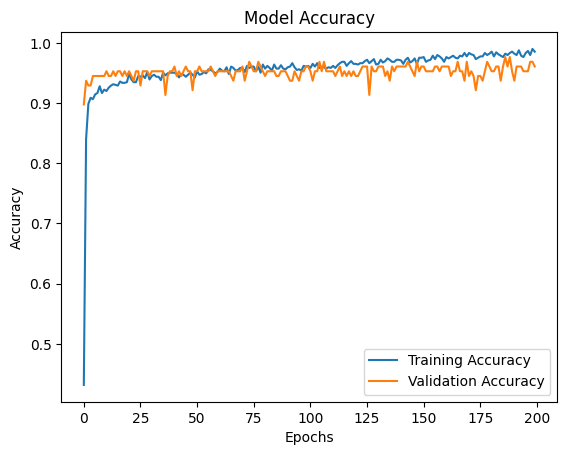

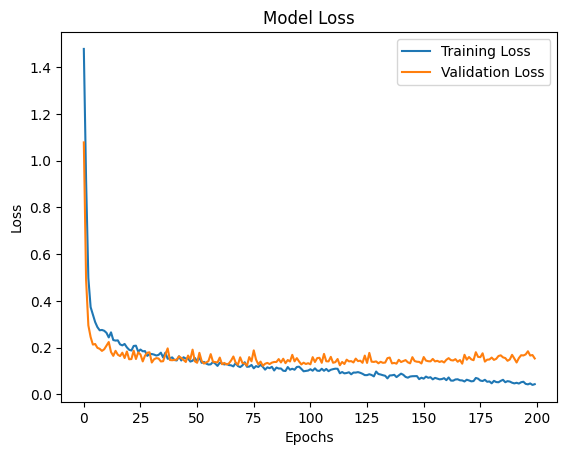

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Confusion Matrix

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


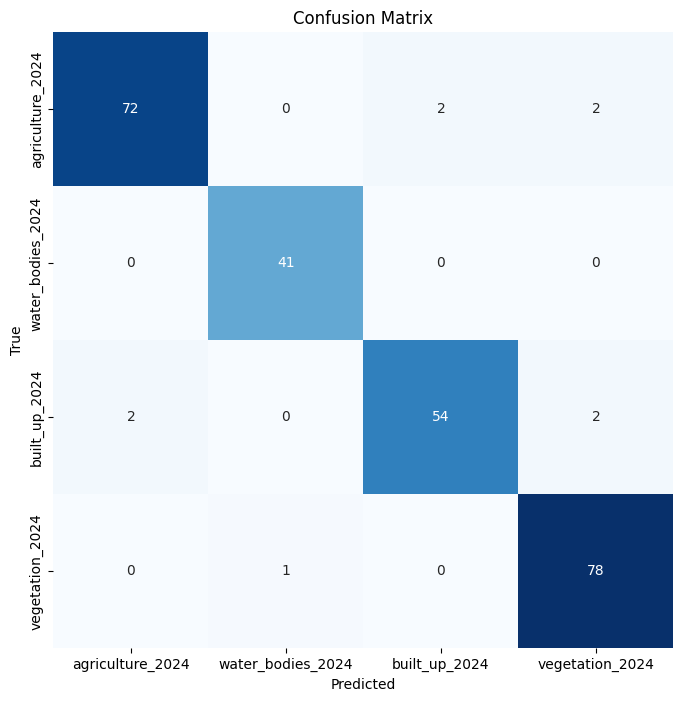

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Make predictions on the test set
y_pred_prob = model.predict(X_test)  # This gives us the predicted probabilities (one-hot encoded)

# Step 2: Convert the predicted probabilities to class labels (indices)
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Get the index of the highest probability

# Step 3: Convert true labels from one-hot encoding to class indices
y_true = np.argmax(Y_test, axis=1)  # Convert true labels from one-hot encoding to class indices

# Step 4: Compute the confusion matrix
c_matrix = confusion_matrix(y_true, y_pred_classes)

# Class names (you can modify these based on your dataset)
names = ['agriculture_2024', 'water_bodies_2024',  'built_up_2024',  'vegetation_2024']

# Step 5: Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(c_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=names, yticklabels=names)

# Set labels and title
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


Compute Precision, Recall, and F1-score

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


# Step 6: Compute Precision, Recall, and F1-score
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and F1-score for each class
precision = precision_score(y_true, y_pred_classes, average=None)  # Per class precision
recall = recall_score(y_true, y_pred_classes, average=None)  # Per class recall
f1 = f1_score(y_true, y_pred_classes, average=None)  # Per class F1-score

# Print the precision, recall, and F1-score for each class
for i, class_name in enumerate(names):
    print(f"{class_name} - Precision: {precision[i]:.4f}, Recall: {recall[i]:.4f}, F1-score: {f1[i]:.4f}")

# Step 7: Calculate overall precision, recall, and F1-score (macro average)
precision_macro = precision_score(y_true, y_pred_classes, average='macro')
recall_macro = recall_score(y_true, y_pred_classes, average='macro')
f1_macro = f1_score(y_true, y_pred_classes, average='macro')

# Print the overall metrics
print("\nOverall (Macro Average) Precision: {:.4f}".format(precision_macro))
print("Overall (Macro Average) Recall: {:.4f}".format(recall_macro))
print("Overall (Macro Average) F1-score: {:.4f}".format(f1_macro))

# Step 8: Print classification report for a summary of all metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=names))

agriculture_2024 - Precision: 0.9730, Recall: 0.9474, F1-score: 0.9600
water_bodies_2024 - Precision: 0.9762, Recall: 1.0000, F1-score: 0.9880
built_up_2024 - Precision: 0.9643, Recall: 0.9310, F1-score: 0.9474
vegetation_2024 - Precision: 0.9512, Recall: 0.9873, F1-score: 0.9689

Overall (Macro Average) Precision: 0.9662
Overall (Macro Average) Recall: 0.9664
Overall (Macro Average) F1-score: 0.9661

Classification Report:
                   precision    recall  f1-score   support

 agriculture_2024       0.97      0.95      0.96        76
water_bodies_2024       0.98      1.00      0.99        41
    built_up_2024       0.96      0.93      0.95        58
  vegetation_2024       0.95      0.99      0.97        79

         accuracy                           0.96       254
        macro avg       0.97      0.97      0.97       254
     weighted avg       0.96      0.96      0.96       254



# Predicting Classification Map for 2019

202648/202648 ━━━━━━━━━━━━━━━━━━━━ 321s 2ms/step


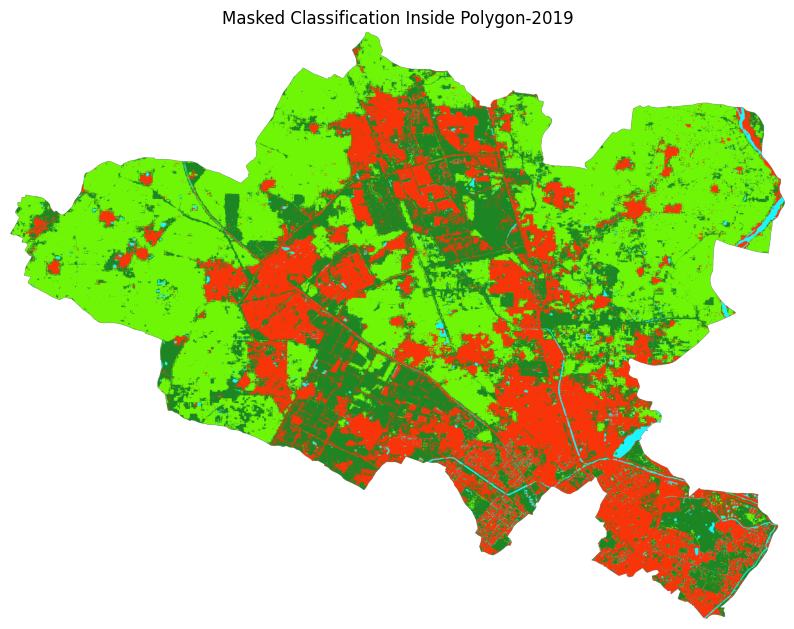

In [ ]:
# Assuming 'model' is your trained CNN model

# Step 1: Preprocess the Sentinel-2 image and reshape it to match the CNN input
# Reshape the image to (height * width, bands)
Predict_img = np.nan_to_num(img)  # Replace NaN values with zeros or another appropriate value
Predict_img = Predict_img.reshape(-1, img.shape[2])  # Shape: (height * width, bands)

# Reshape for CNN model input: we need the data in the format (samples, features, 1)
Predict_img_reshaped = Predict_img.reshape(Predict_img.shape[0], Predict_img.shape[1], 1)  # (height * width, bands, 1)

# Step 2: Make predictions for the entire image using the trained model
y_pred_prob = model.predict(Predict_img_reshaped)  # This will give predicted probabilities for each pixel

# Step 3: Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Get the class index with the highest probability

# Step 4: Reshape the predicted labels back to the image shape (height, width)
array_predict = y_pred_classes.reshape(img.shape[0], img.shape[1])  # Shape: (height, width)

# Assuming 'array_predict' is the classification result (pixel-wise predicted class labels)
array_predict_masked = np.ma.masked_where(np.isnan(out_image[0]), array_predict)

# Ensure that you are masking invalid pixels, not removing them
array_predict_masked_clean = np.ma.masked_invalid(array_predict_masked)

# Visualize the masked classification map
plt.figure(figsize=(10, 10))
plt.imshow(array_predict_masked_clean, cmap=cmap)  # Use your defined colormap
plt.title("Masked Classification Inside Polygon-2019")
plt.axis('off')
plt.show()


Code to Save the Classified Image 2019 as GeoTIFF

In [ ]:
# Code to Save the Classified Image as GeoTIFF
import rasterio
from rasterio.enums import Resampling

# Define output path for the classified image
output_path = '/content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI_19IN_2019_classified_image.tiff'

# Open the original Sentinel-2 image to get metadata
with rasterio.open(path_img) as src:
    meta = src.meta  # Get metadata from the original image

# Update the metadata to reflect the number of channels (1 channel for classification)
meta.update(dtype=rasterio.uint8, count=1)  # Using uint8 as it's a class label (0-255 range)

# Save the classified image to a new GeoTIFF
with rasterio.open(output_path, 'w', **meta) as dest:
    dest.write(array_predict_masked_clean, 1)  # Write the classification result to the first band

print(f"Classified image saved to {output_path}")


Classified image saved to /content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI_19IN_2019_classified_image.tiff


#Analyse Classified Image 2019

In [ ]:
#array_predict.shape
array_predict_masked_clean.shape

(2217, 2925)

In [ ]:
#classes, quantidate = np.unique(array_predict, return_counts = True)
classes, quantidate = np.unique(array_predict_masked_clean, return_counts = True)

In [ ]:
quantidate

array([1420144,   71487,  933255,  912603, 3147236])

In [ ]:
area = quantidate*10*10/1000000

In [ ]:
nomes = ['agriculture_2019',    'water_bodies_2019',    'built_up_2019',   'vegetation_2019', 'others']
dados_stack = np.dstack((classes, quantidate, area, nomes))

In [ ]:
dados_stack

masked_array(
  data=[[['0', '1420144', '142.0144', 'agriculture_2019'],
         ['1', '71487', '7.1487', 'water_bodies_2019'],
         ['2', '933255', '93.3255', 'built_up_2019'],
         ['3', '912603', '91.2603', 'vegetation_2019'],
         ['1', '3147236', '314.7236', 'others']]],
  mask=False,
  fill_value='N/A',
  dtype='<U32')

In [ ]:
dados_stack_3d = np.squeeze(dados_stack)
print(dados_stack_3d)

[['0' '1420144' '142.0144' 'agriculture_2019']
 ['1' '71487' '7.1487' 'water_bodies_2019']
 ['2' '933255' '93.3255' 'built_up_2019']
 ['3' '912603' '91.2603' 'vegetation_2019']
 ['1' '3147236' '314.7236' 'others']]


In [ ]:
df_dados = pd.DataFrame(data=dados_stack_3d, columns=  ['codigos', 'quantidate', 'area km square', 'Classes'])

In [ ]:
df_dados['area km square'] = df_dados['area km square'].astype(np.float64)

In [ ]:
df_dados

codigos quantidate  area km square            Classes
0       0    1420144        142.0144   agriculture_2019
1       1      71487          7.1487  water_bodies_2019
2       2     933255         93.3255      built_up_2019
3       3     912603         91.2603    vegetation_2019
4       1    3147236        314.7236             others

In [ ]:
# Filter out the 'others' class
df_dados_filtered = df_dados[df_dados['Classes'] != 'others']

# Display the filtered DataFrame
print(df_dados_filtered)

  codigos quantidate  area km square            Classes
0       0    1420144        142.0144   agriculture_2019
1       1      71487          7.1487  water_bodies_2019
2       2     933255         93.3255      built_up_2019
3       3     912603         91.2603    vegetation_2019


<ipython-input-44-300e180a85a5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axl = sns.barplot(x = 'Classes', y = 'area km square', data = df_dados_filtered, palette = cmap.colors)


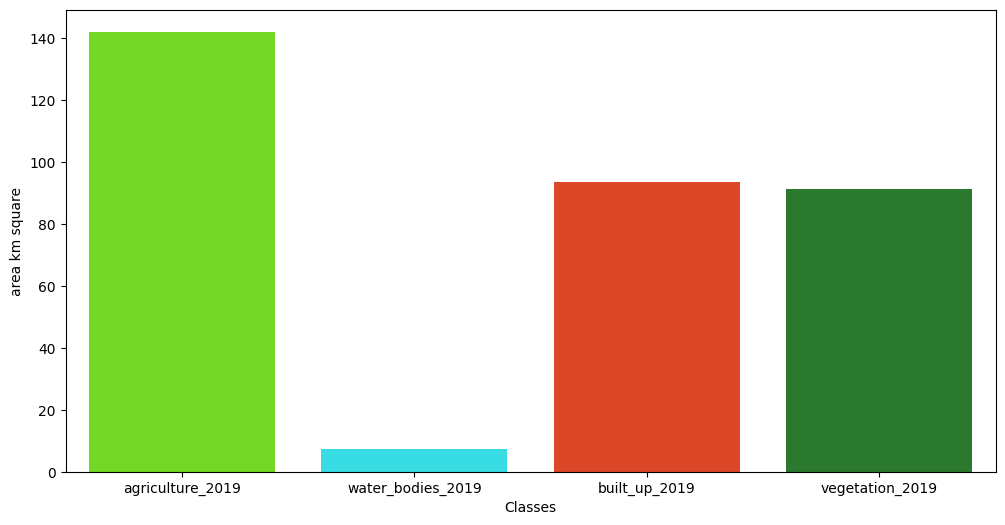

In [ ]:
fig, axl = plt.subplots(figsize = (12,6))
axl = sns.barplot(x = 'Classes', y = 'area km square', data = df_dados_filtered, palette = cmap.colors)

In [ ]:
# Select only the first four values (excluding the 'others' class)
quantidate = quantidate[:4]

In [ ]:
percent = quantidate*100/quantidate.sum()

In [ ]:
percent

array([42.55127133,  2.14193964, 27.96278879, 27.34400023])

# Using above trained model Predicting Classification Map for 2024

(2217, 2925, 19)


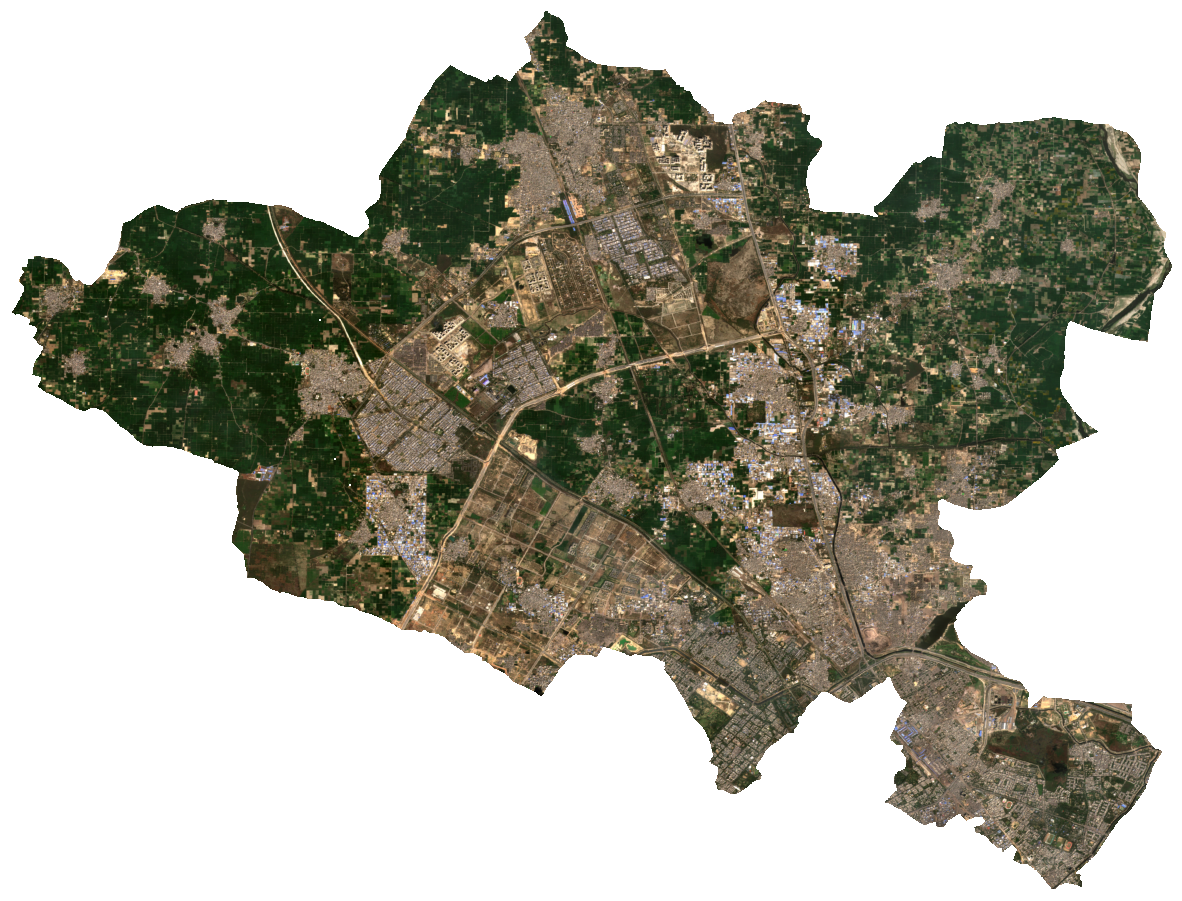

In [ ]:

# Load Sentinel-2 image (GeoTIFF)
path_img = '/content/drive/MyDrive/NORTH_DELHI_19IN_2024/NORTH_DELHI_2024_composite.tif'
src = rasterio.open(path_img)

# Read image data (19 bands)
img = src.read()

img = img.transpose([1, 2, 0])  # Reshape to (height, width, bands)
print(img.shape)
# Select RGB bands for visualization
red = img[:, :, 3]
green = img[:, :, 2]
blue = img[:, :, 1]
rgb = np.dstack((red, green, blue))

# Plot RGB image
plt.figure(figsize=[15, 15])
plt.imshow(rgb * 4)  # Adjust contrast
plt.axis('off')
plt.show()

Predicting for 2024

202648/202648 ━━━━━━━━━━━━━━━━━━━━ 328s 2ms/step


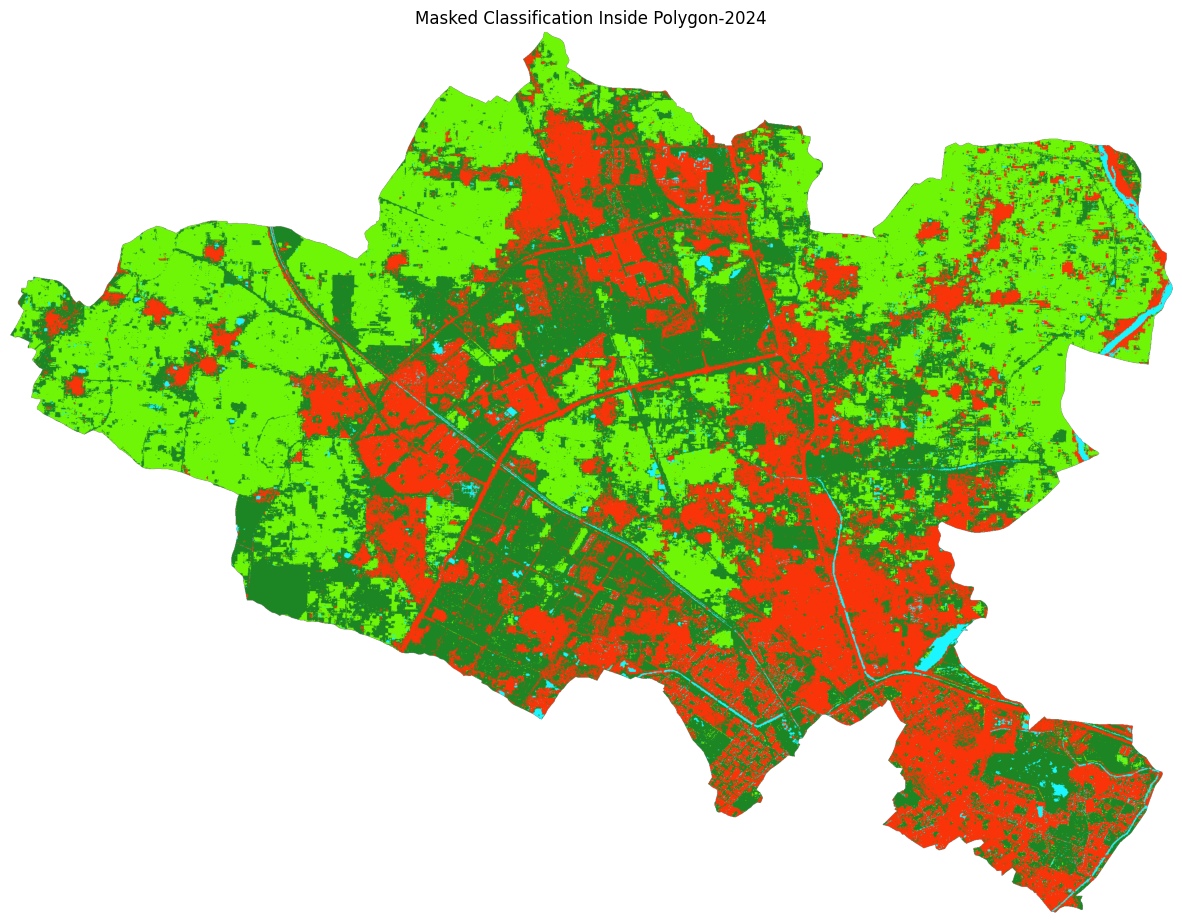

In [ ]:
# Assuming 'model' is your trained CNN model

# Step 1: Preprocess the Sentinel-2 image and reshape it to match the CNN input
# Reshape the image to (height * width, bands)
Predict_img = np.nan_to_num(img)  # Replace NaN values with zeros or another appropriate value
Predict_img = Predict_img.reshape(-1, img.shape[2])  # Shape: (height * width, bands)

# Reshape for CNN model input: we need the data in the format (samples, features, 1)
Predict_img_reshaped = Predict_img.reshape(Predict_img.shape[0], Predict_img.shape[1], 1)  # (height * width, bands, 1)

# Step 2: Make predictions for the entire image using the trained model
y_pred_prob = model.predict(Predict_img_reshaped)  # This will give predicted probabilities for each pixel

# Step 3: Convert predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Get the class index with the highest probability

# Step 4: Reshape the predicted labels back to the image shape (height, width)
array_predict = y_pred_classes.reshape(img.shape[0], img.shape[1])  # Shape: (height, width)

# Assuming 'array_predict' is the classification result (pixel-wise predicted class labels)
array_predict_masked = np.ma.masked_where(np.isnan(out_image[0]), array_predict)

# Ensure that you are masking invalid pixels, not removing them
array_predict_masked_clean = np.ma.masked_invalid(array_predict_masked)

# Visualize the masked classification map
plt.figure(figsize=(15, 15))
plt.imshow(array_predict_masked_clean, cmap=cmap)  # Use your defined colormap
plt.title("Masked Classification Inside Polygon-2024")
plt.axis('off')
plt.show()


Code to Save the Classified Image 2024 as GeoTIFF

In [ ]:
# Code to Save the Classified Image as GeoTIFF
import rasterio
from rasterio.enums import Resampling

# Define output path for the classified image
output_path = '/content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI_19IN_2024_classified_image.tiff'

# Open the original Sentinel-2 image to get metadata
with rasterio.open(path_img) as src:
    meta = src.meta  # Get metadata from the original image

# Update the metadata to reflect the number of channels (1 channel for classification)
meta.update(dtype=rasterio.uint8, count=1)  # Using uint8 as it's a class label (0-255 range)

# Save the classified image to a new GeoTIFF
with rasterio.open(output_path, 'w', **meta) as dest:
    dest.write(array_predict_masked_clean, 1)  # Write the classification result to the first band

print(f"Classified image saved to {output_path}")


Classified image saved to /content/drive/MyDrive/NORTH_DELHI_19IN_2019/NORTH_DELHI_19IN_2024_classified_image.tiff


#Analyse Classified Image 2024

In [ ]:
#array_predict.shape
array_predict_masked_clean.shape

(2217, 2925)

In [ ]:
#classes, quantidate = np.unique(array_predict, return_counts = True)
classes, quantidate = np.unique(array_predict_masked_clean, return_counts = True)

In [ ]:
quantidate

array([1110706,   74249,  949976, 1202558, 3147236])

In [ ]:
area = quantidate*10*10/1000000

In [ ]:
nomes = ['agriculture_2024',    'water_bodies_2024',    'built_up_2024',   'vegetation_2024', 'others']
dados_stack = np.dstack((classes, quantidate, area, nomes))

In [ ]:
dados_stack

masked_array(
  data=[[['0', '1110706', '111.0706', 'agriculture_2024'],
         ['1', '74249', '7.4249', 'water_bodies_2024'],
         ['2', '949976', '94.9976', 'built_up_2024'],
         ['3', '1202558', '120.2558', 'vegetation_2024'],
         ['1', '3147236', '314.7236', 'others']]],
  mask=False,
  fill_value='N/A',
  dtype='<U32')

In [ ]:
dados_stack_3d = np.squeeze(dados_stack)
print(dados_stack_3d)

[['0' '1110706' '111.0706' 'agriculture_2024']
 ['1' '74249' '7.4249' 'water_bodies_2024']
 ['2' '949976' '94.9976' 'built_up_2024']
 ['3' '1202558' '120.2558' 'vegetation_2024']
 ['1' '3147236' '314.7236' 'others']]


In [ ]:
df_dados = pd.DataFrame(data=dados_stack_3d, columns=  ['codigos', 'quantidate', 'area km square', 'Classes'])

In [ ]:
df_dados['area km square'] = df_dados['area km square'].astype(np.float64)

In [ ]:
df_dados

codigos quantidate  area km square            Classes
0       0    1110706        111.0706   agriculture_2024
1       1      74249          7.4249  water_bodies_2024
2       2     949976         94.9976      built_up_2024
3       3    1202558        120.2558    vegetation_2024
4       1    3147236        314.7236             others

In [ ]:
# Filter out the 'others' class
df_dados_filtered = df_dados[df_dados['Classes'] != 'others']

# Display the filtered DataFrame
print(df_dados_filtered)

  codigos quantidate  area km square            Classes
0       0    1110706        111.0706   agriculture_2024
1       1      74249          7.4249  water_bodies_2024
2       2     949976         94.9976      built_up_2024
3       3    1202558        120.2558    vegetation_2024


<ipython-input-63-300e180a85a5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  axl = sns.barplot(x = 'Classes', y = 'area km square', data = df_dados_filtered, palette = cmap.colors)


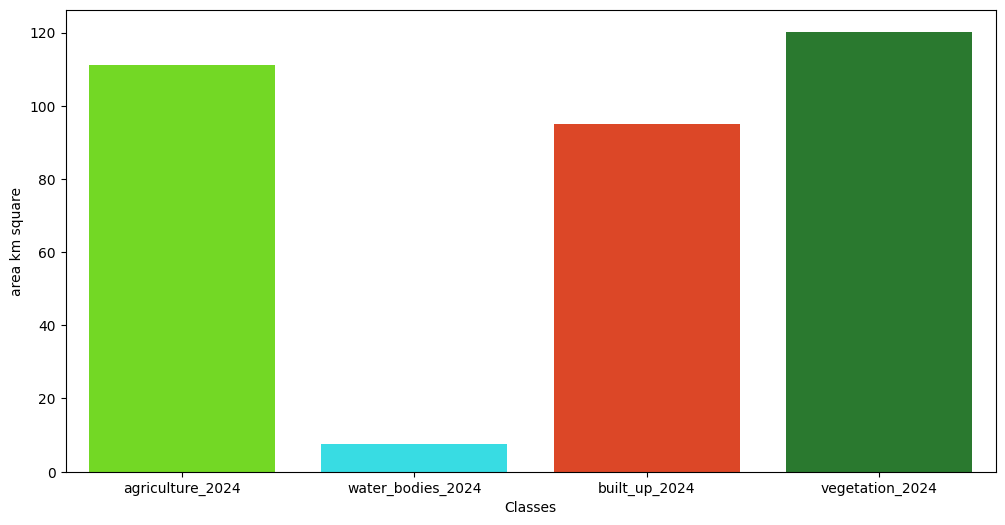

In [ ]:
fig, axl = plt.subplots(figsize = (12,6))
axl = sns.barplot(x = 'Classes', y = 'area km square', data = df_dados_filtered, palette = cmap.colors)

In [ ]:
# Select only the first four values (excluding the 'others' class)
quantidate = quantidate[:4]

In [ ]:
percent = quantidate*100/quantidate.sum()

In [ ]:
percent

array([33.27969021,  2.22469647, 28.46379419, 36.03181913])